# Insect Recognizer

## Introduction

This notebook is the starting point for insect recognizer.

## Data Importing

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

new_dir = "../datasets/initialTestDataSetV2/cleaned"

train_datagen = ImageDataGenerator(
    rescale=1./255,       # normalize pixel values
    rotation_range=20,    # small random rotation
    zoom_range=0.2,       # small random zoom
    horizontal_flip=True  # flip image horizontally
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    new_dir,
    target_size=(224,224),   # resize all images
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

Found 4873 images belonging to 23 classes.


## Data Understanding

### Classes

In [3]:
# Check the class labels detected by the generator
print("Class indices:", train_generator.class_indices)

# Reverse dictionary (to map index -> class name)
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

Class indices: {'ant': 0, 'bee': 1, 'bee_apis': 2, 'bee_bombus': 3, 'beetle': 4, 'beetle_ladybug': 5, 'beetle_oedem': 6, 'butterfly': 7, 'dragonfly': 8, 'fly': 9, 'fly_empi': 10, 'fly_hoverfly_episyr': 11, 'fly_hoverfly_eristal': 12, 'fly_hoverfly_eupeo': 13, 'fly_hoverfly_myathr': 14, 'fly_hoverfly_sphaero': 15, 'fly_hoverfly_syrphus': 16, 'fly_mosquito': 17, 'fly_sarco': 18, 'fly_small': 19, 'grasshopper': 20, 'mecoptera_scorpionfly': 21, 'wasp': 22}
Class labels: ['ant', 'bee', 'bee_apis', 'bee_bombus', 'beetle', 'beetle_ladybug', 'beetle_oedem', 'butterfly', 'dragonfly', 'fly', 'fly_empi', 'fly_hoverfly_episyr', 'fly_hoverfly_eristal', 'fly_hoverfly_eupeo', 'fly_hoverfly_myathr', 'fly_hoverfly_sphaero', 'fly_hoverfly_syrphus', 'fly_mosquito', 'fly_sarco', 'fly_small', 'grasshopper', 'mecoptera_scorpionfly', 'wasp']


### Number of Images

In [4]:
print("Number of training samples:", train_generator.samples)
# print("Number of validation samples:", val_generator.samples)

Number of training samples: 4873


### Some Images

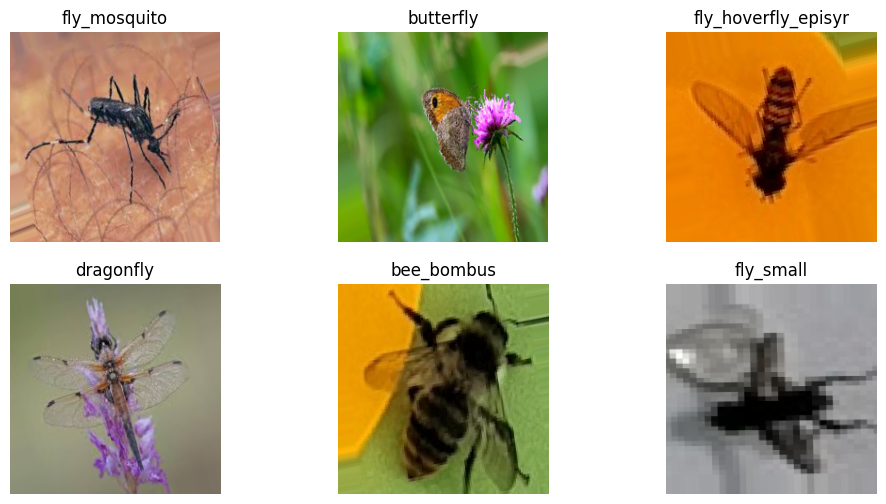

In [5]:
import matplotlib.pyplot as plt

# Get one batch of images and labels
images, labels = next(train_generator)

# Show first 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].argmax()])  # get class name
    plt.axis("off")
plt.show()


### Class Distribution

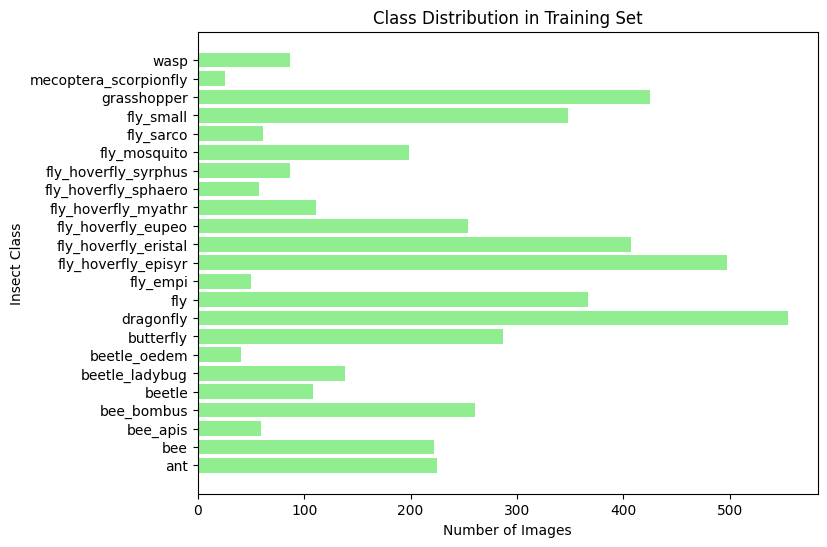

In [6]:
import numpy as np

# Count number of samples for each class in training set
train_counts = np.bincount(train_generator.classes)

# Plot horizontal bar chart
plt.figure(figsize=(8,6))   # bigger figure
plt.barh(class_labels, train_counts, color="lightgreen")
plt.xlabel("Number of Images")
plt.ylabel("Insect Class")
plt.title("Class Distribution in Training Set")
plt.show()


## Data Preparation

### Fixing Class Imbalance

ant: 0.222
bee: 0.225
bee_apis: 0.847
bee_bombus: 0.192
beetle: 0.463
beetle_ladybug: 0.362
butterfly: 0.174
dragonfly: 0.09
fly: 0.136
fly_empi: 1.0
fly_hoverfly_episyr: 0.101
fly_hoverfly_eristal: 0.123
fly_hoverfly_eupeo: 0.197
fly_hoverfly_myathr: 0.45
fly_hoverfly_sphaero: 0.862
fly_hoverfly_syrphus: 0.575
fly_mosquito: 0.251
fly_sarco: 0.82
fly_small: 0.144
grasshopper: 0.118
wasp: 0.575


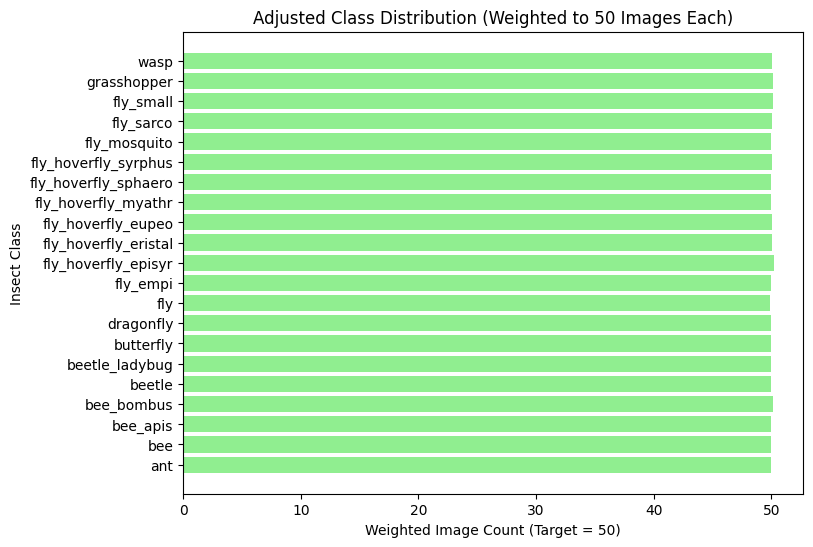

In [7]:
# This value generated by the weight distribution class that need to be taken into account when training the model or to prevent biases.

import numpy as np
import matplotlib.pyplot as plt

# Get counts per class
train_counts = np.bincount(train_generator.classes)
class_labels = list(train_generator.class_indices.keys())

# Convert to numpy array for easy masking
train_counts = np.array(train_counts)
class_labels = np.array(class_labels)

# Exclude classes with too few samples
exclude_classes = ["beetle_oedem", "mecoptera_scorpionfly"]
mask = ~np.isin(class_labels, exclude_classes)

filtered_labels = class_labels[mask]
filtered_counts = train_counts[mask]

# Target number of images per class
target_images = 50

# Calculate class weights so that each class is scaled to 50
# Example: if a class has 200 images, weight = 50 / 200 = 0.25
class_weights = target_images / filtered_counts
class_weights = np.round(class_weights, 3)  # Rounded for readability

# Show calculated weights
for label, weight in zip(filtered_labels, class_weights):
    print(f"{label}: {weight}")

# Optional: visualize adjusted "equalized" distribution
plt.figure(figsize=(8,6))
plt.barh(filtered_labels, filtered_counts * class_weights, color="lightgreen")
plt.xlabel("Weighted Image Count (Target = 50)")
plt.ylabel("Insect Class")
plt.title("Adjusted Class Distribution (Weighted to 50 Images Each)")
plt.show()

# Model Training
## Insect Classification via Transfer Learning (21 Classes)

- Train a 21-class image classifier using transfer learning and evaluate it properly:

- Split: 70% train, 20% validation, 10% test (stratified by class).

- Training: Start from an ImageNet-pretrained backbone and fine-tune.

Evaluation: Select best checkpoint on validation; report final scores on test.

### Model choice

Use Ultralytics – Classify with efficientnet_b0 (ImageNet pretrained).
(It’s simple, fast, and strong for small datasets. We can swap to efficientnet_v2_s later if needed.)

### Data layout

Input (raw): one folder per class (e.g., dataset_raw/<class_name>/*.jpg).
Output (prepared): dataset_insects/{train,val,test}/<class_name>/*.jpg.

### Training settings 

imgsz=384, epochs=50–60, batch≈16, lr0=3e-4, optimizer=AdamW, weight_decay=0.05

Early stopping with patience=10

Augmentations + label smoothing for small data

### Metrics

During/after training: accuracy/F1 on val; final report on test including confusion matrix.

In [8]:
import shutil, random
from pathlib import Path

random.seed(42)

SRC = Path("../datasets/initialTestDataSetV2/cleaned")      
DST = Path("../datasets/initialTestDataSetV2/train_val_test_split")
splits = {"train": 0.7, "val": 0.2, "test": 0.1}
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

for s in splits:
    (DST / s).mkdir(parents=True, exist_ok=True)

for class_dir in sorted(SRC.iterdir()):
    if not class_dir.is_dir():
        continue
    images = [p for p in class_dir.iterdir() if p.suffix.lower() in exts]
    images.sort()
    random.shuffle(images)
    n = len(images)
    n_train = int(round(n * splits["train"]))
    n_val   = int(round(n * splits["val"]))
    n_test  = n - n_train - n_val

    parts = {
        "train": images[:n_train],
        "val":   images[n_train:n_train + n_val],
        "test":  images[n_train + n_val:],
    }

    for split, files in parts.items():
        out_dir = DST / split / class_dir.name
        out_dir.mkdir(parents=True, exist_ok=True)
        for f in files:
            shutil.copy2(f, out_dir / f.name)

print("✅ Split completed.")



✅ Split completed.


### Training 


In [9]:
# --- SETUP (sadece 1 kez) ---
import os, random, json
from pathlib import Path

# OpenMP workaround (Windows'ta libiomp çakışmalarına karşı)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

# Veri kökü: train/ val/ test klasörleri bunun altında
DATA_DIR = Path("../datasets/initialTestDataSetV2/train_val_test_split").resolve()
assert (DATA_DIR / "train").exists() and (DATA_DIR / "val").exists() and (DATA_DIR / "test").exists(), \
    f"Split klasörleri bulunamadı: {DATA_DIR}"

# Proje/çıkış klasörleri (Ultralytics runs)
PROJECT = "insects_cls"
RUN_NAME = "effb0_384"

# Reproducibility (temel seeding)
def set_seed(seed=42):
    random.seed(seed)
    try:
        import numpy as np
        np.random.seed(seed)
    except Exception:
        pass
set_seed(42)

# Hızlı sayım (kontrol)
from collections import Counter
def count_split(root: Path):
    out = {}
    for split in ["train","val","test"]:
        cnt = Counter()
        for c in (root/split).iterdir():
            if c.is_dir():
                cnt[c.name] += len(list(c.glob("*")))
        out[split] = dict(cnt)
    return out

counts = count_split(DATA_DIR)
print("DATA_DIR:", DATA_DIR)
print(json.dumps(counts, indent=2)[:1000])


DATA_DIR: C:\dev_projects_pc\insects\datasets\initialTestDataSetV2\train_val_test_split
{
  "train": {
    "ant": 158,
    "bee": 155,
    "beetle": 76,
    "beetle_ladybug": 97,
    "beetle_oedem": 29,
    "bee_apis": 41,
    "bee_bombus": 183,
    "butterfly": 201,
    "dragonfly": 388,
    "fly": 257,
    "fly_empi": 35,
    "fly_hoverfly_episyr": 348,
    "fly_hoverfly_eristal": 285,
    "fly_hoverfly_eupeo": 178,
    "fly_hoverfly_myathr": 78,
    "fly_hoverfly_sphaero": 41,
    "fly_hoverfly_syrphus": 61,
    "fly_mosquito": 139,
    "fly_sarco": 43,
    "fly_small": 244,
    "grasshopper": 298,
    "mecoptera_scorpionfly": 18,
    "wasp": 61
  },
  "val": {
    "ant": 45,
    "bee": 44,
    "beetle": 22,
    "beetle_ladybug": 28,
    "beetle_oedem": 8,
    "bee_apis": 12,
    "bee_bombus": 52,
    "butterfly": 57,
    "dragonfly": 111,
    "fly": 73,
    "fly_empi": 10,
    "fly_hoverfly_episyr": 99,
    "fly_hoverfly_eristal": 81,
    "fly_hoverfly_eupeo": 51,
    "fly_hoverfly

### Dataset Distribution Check

In [10]:
from collections import Counter

ROOT = Path("../datasets/initialTestDataSetV2/train_val_test_split")
for split in ["train","val","test"]:
    counts = {}
    for d in (ROOT/split).iterdir():
        if d.is_dir():
            counts[d.name] = len(list(d.iterdir()))
    print(f"\n[{split.upper()}]")
    print("Classes:", len(counts))
    print("Avg per class:", sum(counts.values()) / len(counts))



[TRAIN]
Classes: 23
Avg per class: 148.43478260869566

[VAL]
Classes: 23
Avg per class: 42.30434782608695

[TEST]
Classes: 23
Avg per class: 21.130434782608695


### Train Balanced Set

In [11]:
import os, random, shutil, numpy as np
from pathlib import Path

random.seed(42)

ROOT = Path("../datasets/initialTestDataSetV2/train_val_test_split")
SRC  = ROOT / "train"
DST  = ROOT / "train_balanced"
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

DST.mkdir(parents=True, exist_ok=True)

# classes and counts
classes = sorted([d for d in SRC.iterdir() if d.is_dir()])
counts = {}
for d in classes:
    imgs = [p for p in d.iterdir() if p.is_file() and p.suffix.lower() in EXTS]
    counts[d.name] = len(imgs)

arr = np.array(list(counts.values()), dtype=int)

target = int(np.percentile(arr[arr > 0], 80)) if np.any(arr > 0) else 0
target = max(target, 16)   
target = min(target, 400)  

print(f"TARGET per class = {target}")

for cdir in classes:
    cname = cdir.name
    src_imgs = [p for p in cdir.iterdir() if p.is_file() and p.suffix.lower() in EXTS]
    n = len(src_imgs)
    if n == 0:
        print(f"[UYARI] '{cname}' sınıfı boş; atlanıyor.")
        continue

    out = DST / cname
    out.mkdir(parents=True, exist_ok=True)

    for p in src_imgs:
        dst_path = out / p.name
        try:
            if not dst_path.exists():
                shutil.copy2(p, dst_path)
        except Exception as e:
            print(f"[HATA] Orijinal kopya: {p.name} -> {e}")

    if n < target:
        need = target - n
        base_idx = 0
        chosen = random.choices(src_imgs, k=need)
        for i, p in enumerate(chosen, start=1):
            short_name = f"dup_{i:04d}{p.suffix.lower()}"  
            dst_path = out / short_name
            try:
                while dst_path.exists():
                    base_idx += 1
                    short_name = f"dup_{i:04d}_{base_idx}{p.suffix.lower()}"
                    dst_path = out / short_name
                shutil.copy2(p, dst_path)
            except Exception as e:
                print(f"[HATA] Dup yazılamadı ({cname}): {short_name} -> {e}")

print("✅ train_balanced oluşturuldu.")


TARGET per class = 251
✅ train_balanced oluşturuldu.


### Class Weights Diagnostic

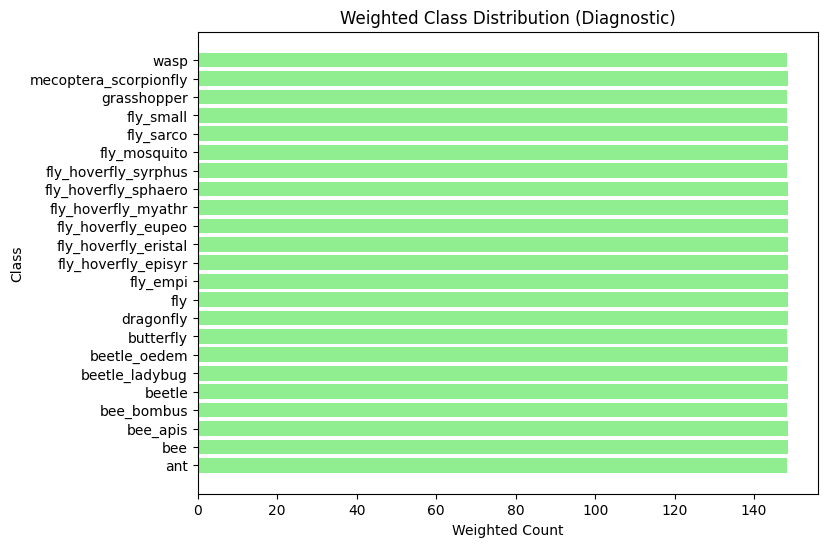

In [12]:
import numpy as np
import matplotlib.pyplot as plt

train_root = ROOT / "train"
classes = sorted([d.name for d in train_root.iterdir() if d.is_dir()])
counts = np.array([len(list((train_root / c).iterdir())) for c in classes])
target = counts.mean()
weights = np.round(target / np.maximum(counts, 1), 3)

plt.figure(figsize=(8,6))
plt.barh(classes, counts * weights, color='lightgreen')
plt.title("Weighted Class Distribution (Diagnostic)")
plt.xlabel("Weighted Count")
plt.ylabel("Class")
plt.show()

In [13]:
import torch, timm, ultralytics

print("torch:", torch.__version__)
print("timm :", timm.__version__)
print("ultralytics:", ultralytics.__version__)
print("cuda available:", torch.cuda.is_available())


c:\dev_projects_pc\insects\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.7.0+cu118
timm : 1.0.20
ultralytics: 8.3.207
cuda available: True


### YAML Config

In [14]:
import yaml

data_cfg = {
    "path": str(ROOT),
    "train": "train_balanced",  
    "val": "val",
    "test": "test",
    "names": {i: d.name for i, d in enumerate(sorted([d for d in (ROOT/'train').iterdir() if d.is_dir()]))}
}

with open("cls.yaml", "w") as f:
    yaml.dump(data_cfg, f)

print("✅ cls.yaml created.")


✅ cls.yaml created.


### Model Training (Ultralytics)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")
model.train(
    data="../datasets/initialTestDataSetV2/train_val_test_split",
    model="timm/efficientnet_b0",
    epochs=60,
    imgsz=384,
    batch=16,
    optimizer="AdamW",
    lr0=3e-4,
    weight_decay=0.05,
    patience=10,
    label_smoothing=0.1,
    augment=True,
    amp=True,
    cos_lr=True
)


WARNING 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.207  Python-3.10.0 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=../datasets/initialTestDataSetV2/train_val_test_split, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=384, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=timm/efficientnet_b0, momentum=0.937, mosaic=1.0, multi_scale=False, name=train20, nbs=

KeyboardInterrupt: 

### Evaluate on Test

In [ ]:
model = YOLO("../runs/classify/train19/weights/best.pt")
metrics = model.val(data="cls.yaml", split="test", plots=True)
print(metrics)


Ultralytics 8.3.207  Python-3.10.0 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,464,343 parameters, 0 gradients, 3.3 GFLOPs
test: Fast image access  (ping: 0.10.1 ms, read: 52.619.1 MB/s, size: 17.1 KB)
test: Scanning C:\dev_projects_pc\insects\datasets\initialTestDataSetV2\train_val_test_split\test... 486 images, 0 corrupt: 100% ━━━━━━━━━━━━ 486/486 323.3Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 31/31 14.1it/s 2.2s0.2s
                   all      0.953      0.996
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\dev_projects_pc\insects\runs\classify\val4
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000014B81748D30>
curves: []
curves_results: []
fitness: 0.9742798507213593
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metr